# Vision Transformer (ViT) 训练 - CIFAR-10

本 Notebook 实现了 ViT 在 CIFAR-10 数据集上的完整训练流程。

## 训练配置
- 配置文件：configs/vit_base.yaml
- 数据集：CIFAR-10 (32x32 彩色图像，10分类)
- 模型：Vision Transformer
- 输出结构：logs/、runs/、checkpoints/

## 1. 导入依赖库

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import os
import sys
import re
import json
import platform
import socket
import subprocess
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

from vit import VisionTransformer

print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA 设备: {torch.cuda.get_device_name(0)}")

PyTorch 版本: 2.9.1+cu130
CUDA 可用: True
CUDA 设备: NVIDIA GeForce RTX 5070 Ti Laptop GPU


## 2. 超参数配置

In [2]:
CONFIG_PATH = Path('configs/vit_base.yaml')

def _parse_scalar(value):
    if value is None:
        return None
    if isinstance(value, (int, float, bool)):
        return value
    text = str(value).strip()
    if text.lower() in {'true', 'false'}:
        return text.lower() == 'true'
    if text.lower() in {'null', 'none', '~'}:
        return None
    try:
        if re.fullmatch(r'[+-]?\d+', text):
            return int(text)
        if re.fullmatch(r'[+-]?(\d+\.\d*|\d*\.\d+)([eE][+-]?\d+)?', text) or re.fullmatch(r'[+-]?\d+[eE][+-]?\d+', text):
            return float(text)
    except Exception:
        pass
    if (text.startswith('"') and text.endswith('"')) or (text.startswith("'") and text.endswith("'")):
        return text[1:-1]
    return text


def load_yaml(path: Path):
    try:
        import yaml as _yaml
        with path.open('r', encoding='utf-8') as f:
            return _yaml.safe_load(f)
    except Exception:
        lines = []
        with path.open('r', encoding='utf-8') as f:
            for raw in f:
                if '#' in raw:
                    raw = raw.split('#', 1)[0]
                if raw.strip() == '':
                    continue
                lines.append(raw.rstrip('\n'))

        root = {}
        stack = [(0, root)]

        def current_container(indent):
            while stack and indent < stack[-1][0]:
                stack.pop()
            return stack[-1][1]

        for idx, line in enumerate(lines):
            indent = len(line) - len(line.lstrip(' '))
            stripped = line.strip()
            container = current_container(indent)

            if stripped.startswith('- '):
                item_text = stripped[2:].strip()
                if not isinstance(container, list):
                    raise ValueError('YAML parser only supports lists under explicit keys')
                container.append(_parse_scalar(item_text))
                continue

            if ':' not in stripped:
                raise ValueError(f'Invalid YAML line: {line}')
            key, rest = stripped.split(':', 1)
            key = key.strip()
            rest = rest.strip()

            if rest == '':
                next_container = {}
                for j in range(idx + 1, len(lines)):
                    nxt = lines[j]
                    nxt_indent = len(nxt) - len(nxt.lstrip(' '))
                    if nxt.strip() == '':
                        continue
                    if nxt_indent <= indent:
                        break
                    if nxt.strip().startswith('- '):
                        next_container = []
                    break
                container[key] = next_container
                stack.append((indent + 2, next_container))
            else:
                if rest.startswith('[') and rest.endswith(']'):
                    inner = rest[1:-1].strip()
                    if inner == '':
                        container[key] = []
                    else:
                        parts = [p.strip() for p in inner.split(',')]
                        container[key] = [_parse_scalar(p) for p in parts]
                else:
                    container[key] = _parse_scalar(rest)

        return root


def dump_yaml(data, path: Path):
    try:
        import yaml as _yaml
        with path.open('w', encoding='utf-8') as f:
            _yaml.safe_dump(data, f, sort_keys=False, allow_unicode=True)
        return
    except Exception:
        def _dump(obj, indent=0):
            spaces = ' ' * indent
            if isinstance(obj, dict):
                out = []
                for k, v in obj.items():
                    if isinstance(v, (dict, list)):
                        out.append(f'{spaces}{k}:')
                        out.extend(_dump(v, indent + 2))
                    else:
                        if isinstance(v, bool):
                            vs = 'true' if v else 'false'
                        elif v is None:
                            vs = 'null'
                        else:
                            vs = str(v)
                        out.append(f'{spaces}{k}: {vs}')
                return out
            if isinstance(obj, list):
                out = []
                for item in obj:
                    if isinstance(item, (dict, list)):
                        out.append(f'{spaces}-')
                        out.extend(_dump(item, indent + 2))
                    else:
                        if isinstance(item, bool):
                            vs = 'true' if item else 'false'
                        elif item is None:
                            vs = 'null'
                        else:
                            vs = str(item)
                        out.append(f'{spaces}- {vs}')
                return out
            return [f'{spaces}{str(obj)}']

        text = '\n'.join(_dump(data)) + '\n'
        path.write_text(text, encoding='utf-8')


def get_next_exp_id(logs_root: Path):
    logs_root.mkdir(parents=True, exist_ok=True)
    max_id = 0
    for p in logs_root.iterdir():
        if not p.is_dir():
            continue
        m = re.fullmatch(r'exp_(\d+)', p.name)
        if m:
            max_id = max(max_id, int(m.group(1)))
    return f'exp_{max_id + 1:03d}'


cfg = load_yaml(CONFIG_PATH)
EXP_ID = get_next_exp_id(Path('logs'))
LOG_DIR = Path('logs') / EXP_ID
RUN_DIR = Path('runs') / EXP_ID
CKPT_DIR = Path('checkpoints') / EXP_ID
LOG_DIR.mkdir(parents=True, exist_ok=True)
RUN_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

dump_yaml(cfg, LOG_DIR / 'config.yaml')

env = {
    'timestamp': __import__('datetime').datetime.now().isoformat(),
    'python_version': sys.version.split(' ')[0],
    'pytorch_version': torch.__version__,
    'cuda_available': torch.cuda.is_available(),
    'cuda_version': getattr(torch.version, 'cuda', None),
    'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
    'hostname': socket.gethostname(),
    'platform': platform.platform(),
}
(LOG_DIR / 'env.json').write_text(json.dumps(env, indent=2, ensure_ascii=False) + '\n', encoding='utf-8')

def _try_git(cmd):
    try:
        return subprocess.check_output(['git'] + cmd, text=True, stderr=subprocess.STDOUT).strip()
    except Exception as e:
        return f'Unavailable: {e}'

git_text = '\n'.join([
    f"Commit: {_try_git(['rev-parse', 'HEAD'])}",
    f"Branch: {_try_git(['rev-parse', '--abbrev-ref', 'HEAD'])}",
    '',
    'Status:',
    _try_git(['status', '--porcelain']),
]) + '\n'
(LOG_DIR / 'git.txt').write_text(git_text, encoding='utf-8')

seed = int(cfg.get('experiment', {}).get('seed', 42))
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

training_cfg = cfg.get('training', {})
model_cfg = cfg.get('model', {})
data_cfg = cfg.get('data', {})
aug_cfg = cfg.get('augmentation', {})
logging_cfg = cfg.get('logging', {})

BATCH_SIZE = int(training_cfg.get('batch_size', 32))
LEARNING_RATE = float(training_cfg.get('learning_rate', 1e-4))
WEIGHT_DECAY = float(training_cfg.get('weight_decay', 0.05))
EPOCHS = int(training_cfg.get('epochs', 10))
NUM_WORKERS = int(training_cfg.get('num_workers', 2))
PRINT_FREQ = int(training_cfg.get('print_freq', 100))
SAVE_FREQ = int(training_cfg.get('save_freq', 1))

IMG_SIZE = int(model_cfg.get('img_size', 32))
PATCH_SIZE = int(model_cfg.get('patch_size', 4))
NUM_CLASSES = int(model_cfg.get('num_classes', 10))
EMBED_DIM = int(model_cfg.get('embed_dim', 256))
DEPTH = int(model_cfg.get('depth', 6))
NUM_HEADS = int(model_cfg.get('num_heads', 8))

DATA_DIR = str(data_cfg.get('data_dir', './data'))
NORMALIZE_MEAN = tuple(data_cfg.get('normalize_mean', [0.4914, 0.4822, 0.4465]))
NORMALIZE_STD = tuple(data_cfg.get('normalize_std', [0.2023, 0.1994, 0.2010]))

RANDOM_CROP = bool(aug_cfg.get('random_crop', True))
CROP_PADDING = int(aug_cfg.get('crop_padding', 4))
RANDOM_HORIZONTAL_FLIP = bool(aug_cfg.get('random_horizontal_flip', True))

TENSORBOARD_ENABLED = bool(logging_cfg.get('tensorboard', True))
LOG_INTERVAL = int(logging_cfg.get('log_interval', 10))
SAVE_LOGS = bool(logging_cfg.get('save_logs', True))

TRAIN_JSONL_PATH = LOG_DIR / 'train.jsonl'
VAL_JSONL_PATH = LOG_DIR / 'val.jsonl'
BEST_CKPT_PATH = CKPT_DIR / 'best_model.pth'

print("=" * 50)
print("训练配置")
print("=" * 50)
print(f"实验ID: {EXP_ID}")
print(f"配置文件: {CONFIG_PATH}")
print(f"日志目录: {LOG_DIR}")
print(f"TensorBoard: {RUN_DIR}")
print(f"Checkpoint: {CKPT_DIR}")
print(f"设备: {DEVICE}")
print(f"批次大小: {BATCH_SIZE}")
print(f"学习率: {LEARNING_RATE}")
print(f"训练轮数: {EPOCHS}")
print(f"模型配置: Embed={EMBED_DIM}, Depth={DEPTH}, Heads={NUM_HEADS}")
print("=" * 50)

训练配置
实验ID: exp_003
配置文件: configs/vit_base.yaml
日志目录: logs/exp_003
TensorBoard: runs/exp_003
Checkpoint: checkpoints/exp_003
设备: cuda
批次大小: 32
学习率: 0.0001
训练轮数: 10
模型配置: Embed=256, Depth=6, Heads=8


## 3. 数据加载与预处理

In [3]:
# 训练集数据增强
train_transforms = []
if RANDOM_CROP:
    train_transforms.append(transforms.RandomCrop(IMG_SIZE, padding=CROP_PADDING))
if RANDOM_HORIZONTAL_FLIP:
    train_transforms.append(transforms.RandomHorizontalFlip())
train_transforms.extend([
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])
transform_train = transforms.Compose(train_transforms)

# 测试集预处理
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])

# 加载数据集
print("正在加载 CIFAR-10 数据集...")
train_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=True, 
    download=True, 
    transform=transform_train
)

test_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=transform_test
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print(f"✅ 数据加载完成")
print(f"训练集: {len(train_dataset)} 样本, {len(train_loader)} 批次")
print(f"测试集: {len(test_dataset)} 样本, {len(test_loader)} 批次")

# CIFAR-10 类别名称
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

正在加载 CIFAR-10 数据集...
✅ 数据加载完成
训练集: 50000 样本, 1563 批次
测试集: 10000 样本, 313 批次


## 4. 可视化样本数据

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.6891968].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7279667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.291557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.6705607].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7

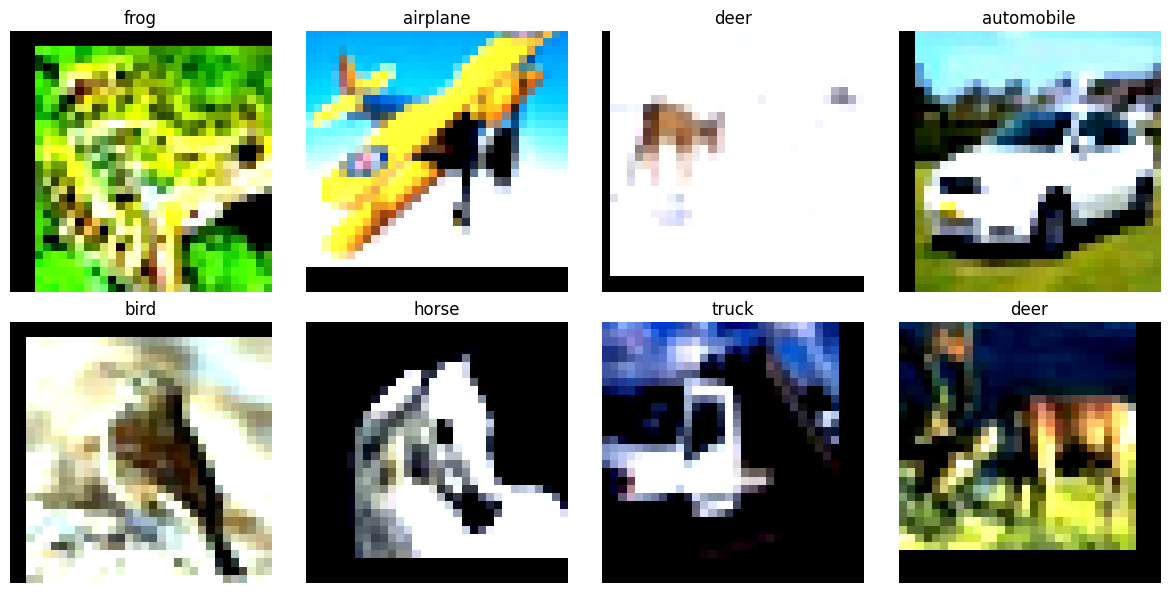

样本形状: torch.Size([32, 3, 32, 32])
标签形状: torch.Size([32])


In [4]:
# 显示一些训练样本
def imshow(img, title=None):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# 获取一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 显示前8张图片
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    if idx < 8:
        ax.imshow(np.transpose(images[idx].numpy() / 2 + 0.5, (1, 2, 0)))
        ax.set_title(classes[labels[idx]])
        ax.axis('off')
plt.tight_layout()
plt.show()

print(f"样本形状: {images.shape}")
print(f"标签形状: {labels.shape}")

## 5. 初始化模型

In [5]:
# 创建模型
model = VisionTransformer(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    in_chans=3,
    embed_dim=EMBED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    num_classes=NUM_CLASSES,
).to(DEVICE)

# 统计参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 50)
print("模型信息")
print("=" * 50)
print(f"总参数量: {total_params:,}")
print(f"可训练参数量: {trainable_params:,}")
print(f"模型大小: {total_params * 4 / 1024 / 1024:.2f} MB (FP32)")
print("=" * 50)

# 测试前向传播
with torch.no_grad():
    test_input = torch.randn(2, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    test_output = model(test_input)
    print(f"\n✅ 模型前向传播测试通过")
    print(f"输入形状: {test_input.shape}")
    print(f"输出形状: {test_output.shape}")

模型信息
总参数量: 4,771,082
可训练参数量: 4,771,082
模型大小: 18.20 MB (FP32)

✅ 模型前向传播测试通过
输入形状: torch.Size([2, 3, 32, 32])
输出形状: torch.Size([2, 10])


## 6. 设置训练组件

In [6]:
# 损失函数
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer_cfg = cfg.get('optimizer', {})
optimizer_type = str(optimizer_cfg.get('type', 'AdamW'))
if optimizer_type.lower() != 'adamw':
    raise ValueError(f'Unsupported optimizer: {optimizer_type}')
betas = tuple(optimizer_cfg.get('betas', (0.9, 0.999)))
eps = float(optimizer_cfg.get('eps', 1e-8))
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=betas,
    eps=eps,
)

# 学习率调度器
scheduler_cfg = cfg.get('scheduler', {})
scheduler_type = str(scheduler_cfg.get('type', 'CosineAnnealing'))
if scheduler_type.lower() not in {'cosineannealing', 'cosineannealinglr', 'cosine'}:
    raise ValueError(f'Unsupported scheduler: {scheduler_type}')
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=int(scheduler_cfg.get('T_max', EPOCHS)),
)

print("✅ 训练组件初始化完成")
print(f"优化器: {optimizer_type}")
print(f"学习率调度: {scheduler_type}")
print(f"损失函数: CrossEntropyLoss")

✅ 训练组件初始化完成
优化器: AdamW
学习率调度: CosineAnnealing
损失函数: CrossEntropyLoss


## 7. 定义训练和测试函数

In [7]:
def train_one_epoch(epoch, history):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 统计
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # 打印进度
        if (batch_idx + 1) % PRINT_FREQ == 0:
            avg_loss = running_loss / (batch_idx + 1)
            acc = 100. * correct / total
            print(f'  [{epoch+1}/{EPOCHS}] [{batch_idx+1}/{len(train_loader)}] '
                  f'Loss: {avg_loss:.4f} Acc: {acc:.2f}%')
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, epoch_time


def test(epoch):
    """测试模型"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc


def plot_history(history):
    """绘制训练历史"""
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss曲线
    ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    ax1.plot(epochs_range, history['test_loss'], 'r-s', label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Test Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy曲线
    ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    ax2.plot(epochs_range, history['test_acc'], 'r-s', label='Test Acc', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ 训练函数定义完成")

✅ 训练函数定义完成


## 8. 开始训练

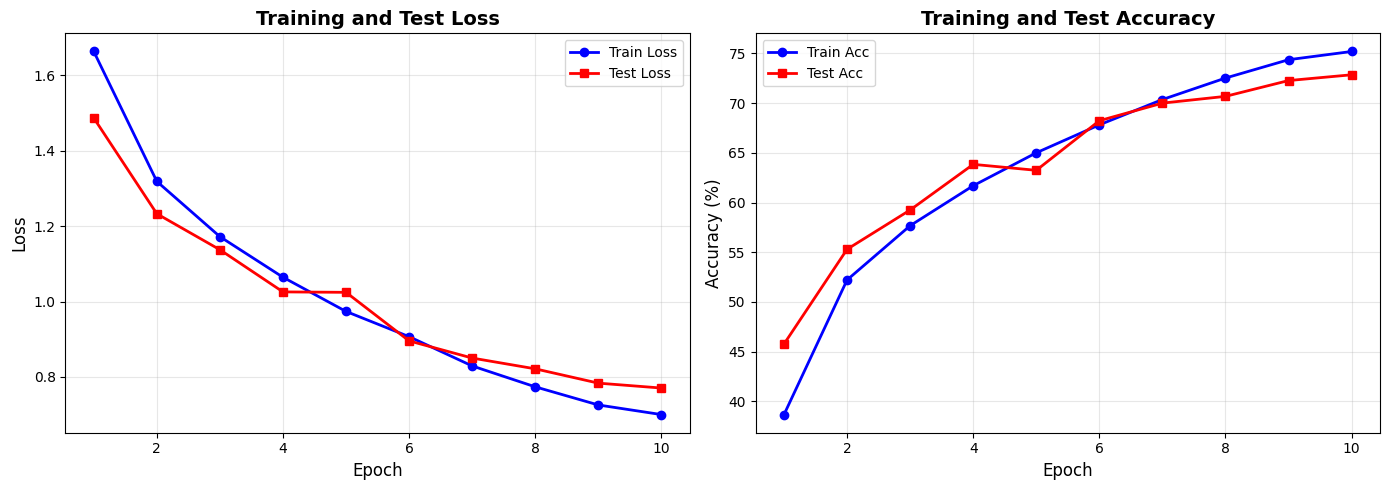


训练完成！
最佳测试准确率: 72.85%


In [8]:
print("=" * 50)
print("开始训练")
print("=" * 50)

best_acc = 0.0
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
    'lr': []
}

def append_jsonl(path: Path, record: dict):
    with path.open('a', encoding='utf-8') as f:
        f.write(json.dumps(record, ensure_ascii=False) + '\n')

writer = None
if TENSORBOARD_ENABLED:
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(str(RUN_DIR))

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*50}")
    
    # 训练
    train_loss, train_acc, epoch_time = train_one_epoch(epoch, history)
    
    # 测试
    test_loss, test_acc = test(epoch)
    
    # 更新学习率
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)
    
    # 打印总结
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{EPOCHS} 完成 (用时: {epoch_time:.1f}s)")
    print(f"学习率: {current_lr:.6f}")
    print(f"训练 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"测试 - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

    if SAVE_LOGS:
        append_jsonl(TRAIN_JSONL_PATH, {
            'epoch': epoch + 1,
            'loss': train_loss,
            'acc': train_acc,
            'lr': current_lr,
            'time_sec': epoch_time,
        })
        append_jsonl(VAL_JSONL_PATH, {
            'epoch': epoch + 1,
            'loss': test_loss,
            'acc': test_acc,
        })

    if writer is not None:
        writer.add_scalar('loss/train', train_loss, epoch + 1)
        writer.add_scalar('loss/val', test_loss, epoch + 1)
        writer.add_scalar('acc/train', train_acc, epoch + 1)
        writer.add_scalar('acc/val', test_acc, epoch + 1)
        writer.add_scalar('lr', current_lr, epoch + 1)
        writer.flush()
    
    # 保存最佳模型
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
            'history': history,
        }, str(BEST_CKPT_PATH))
        print(f"✅ 保存最佳模型 (准确率: {test_acc:.2f}%)")

    if (epoch + 1) % SAVE_FREQ == 0 or (epoch + 1) == EPOCHS:
        ckpt_path = CKPT_DIR / f'epoch_{epoch + 1}.pth'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
            'history': history,
        }, str(ckpt_path))
        print(f"✅ 保存Checkpoint: {ckpt_path.name}")
    
    print(f"{'='*50}")
    
    # 实时绘制训练曲线
    if epoch > 0:  # 至少有2个点才绘制
        clear_output(wait=True)
        plot_history(history)

if writer is not None:
    writer.close()

print("\n" + "="*50)
print("训练完成！")
print(f"最佳测试准确率: {best_acc:.2f}%")
print("="*50)

## 9. 可视化训练结果

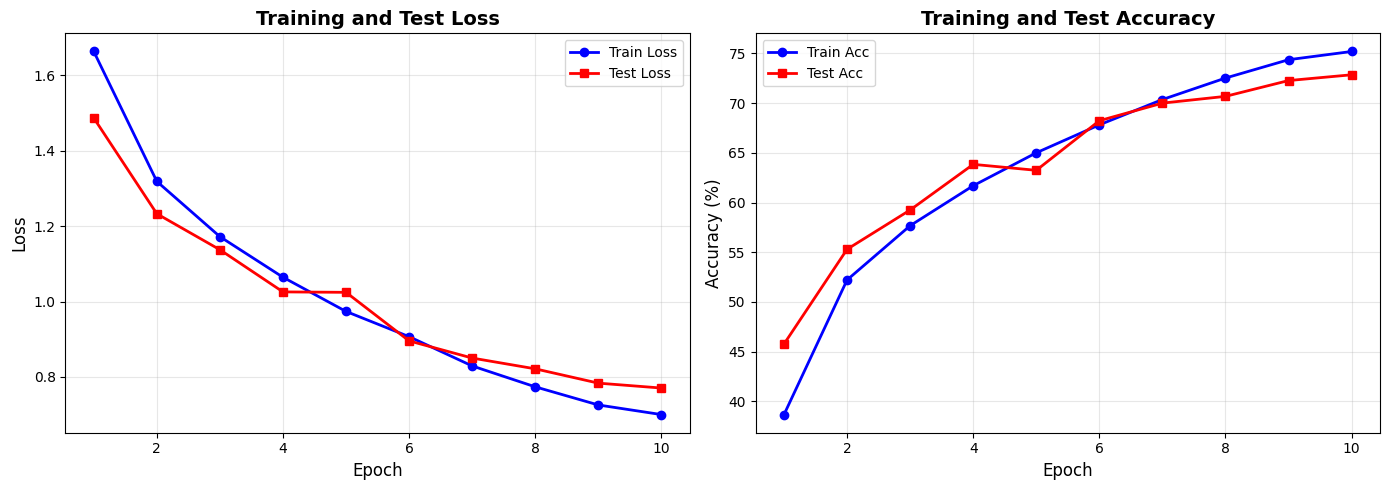


训练历史详情:
Epoch   Train Loss  Train Acc   Test Loss   Test Acc    LR          
----------------------------------------------------------------------
1       1.6632      38.67       1.4868      45.77       0.000098    
2       1.3185      52.22       1.2327      55.30       0.000090    
3       1.1720      57.67       1.1373      59.25       0.000079    
4       1.0644      61.69       1.0255      63.84       0.000065    
5       0.9736      65.00       1.0243      63.24       0.000050    
6       0.9067      67.82       0.8955      68.23       0.000035    
7       0.8291      70.36       0.8500      70.00       0.000021    
8       0.7737      72.52       0.8214      70.68       0.000010    
9       0.7256      74.37       0.7835      72.27       0.000002    
10      0.7001      75.19       0.7705      72.85       0.000000    


In [9]:
# 绘制最终训练曲线
plot_history(history)

# 打印训练历史表格
print("\n训练历史详情:")
print(f"{'Epoch':<8}{'Train Loss':<12}{'Train Acc':<12}{'Test Loss':<12}{'Test Acc':<12}{'LR':<12}")
print("-" * 70)
for i in range(len(history['train_loss'])):
    print(f"{i+1:<8}{history['train_loss'][i]:<12.4f}{history['train_acc'][i]:<12.2f}"
          f"{history['test_loss'][i]:<12.4f}{history['test_acc'][i]:<12.2f}{history['lr'][i]:<12.6f}")

## 10. 测试模型预测

## 11. 分析每个类别的性能

✅ 加载最佳模型 (Epoch 10, 准确率: 72.85%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

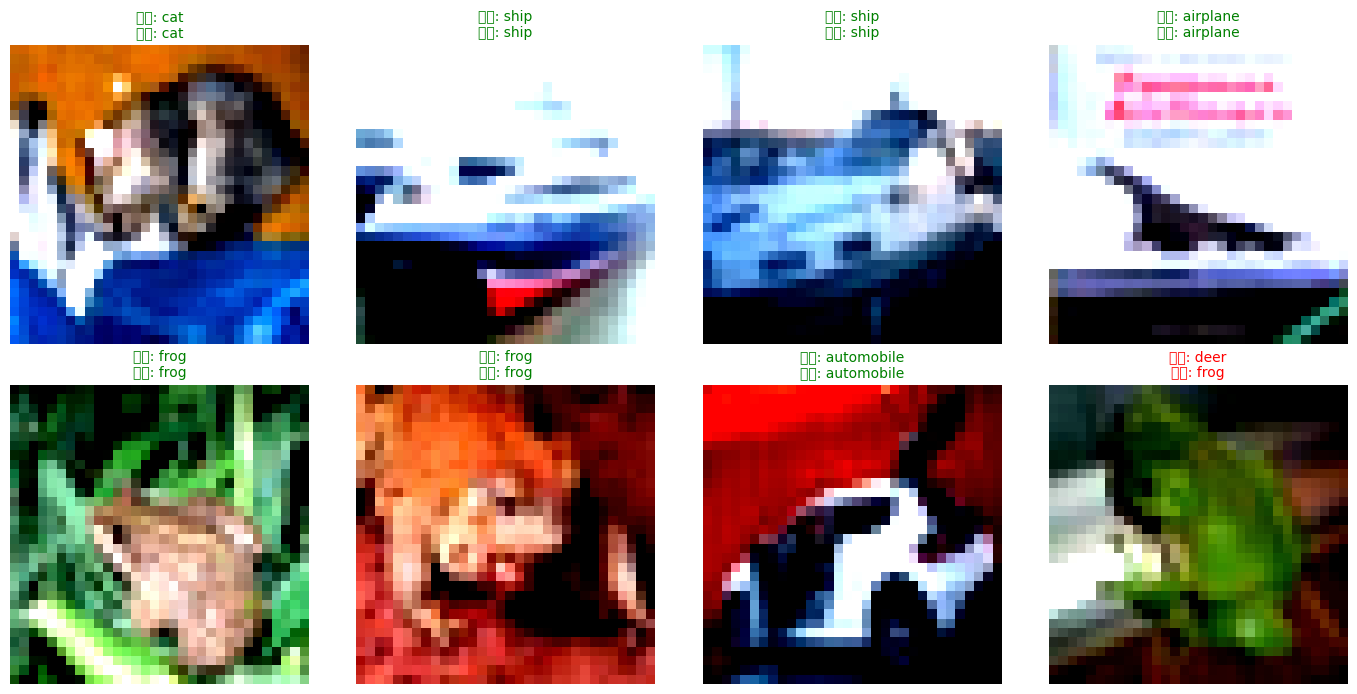


这批样本的准确率: 87.50% (28/32)


In [10]:
# 加载最佳模型
checkpoint = torch.load(str(BEST_CKPT_PATH), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ 加载最佳模型 (Epoch {checkpoint['epoch']}, 准确率: {checkpoint['test_acc']:.2f}%)")

# 获取测试样本
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)

# 预测
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# 可视化预测结果
images_np = images.cpu()
predicted_np = predicted.cpu()
labels_np = labels.cpu()

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for idx, ax in enumerate(axes.flat):
    if idx < 8:
        img = images_np[idx].numpy() / 2 + 0.5
        ax.imshow(np.transpose(img, (1, 2, 0)))
        
        pred_label = classes[predicted_np[idx]]
        true_label = classes[labels_np[idx]]
        color = 'green' if predicted_np[idx] == labels_np[idx] else 'red'
        
        ax.set_title(f'预测: {pred_label}\n真实: {true_label}', color=color, fontsize=10)
        ax.axis('off')
        
plt.tight_layout()
plt.show()

# 计算准确率
correct = (predicted_np == labels_np).sum().item()
print(f"\n这批样本的准确率: {100. * correct / len(labels):.2f}% ({correct}/{len(labels)})")

✅ 加载最佳模型 (Epoch 10, 准确率: 72.85%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

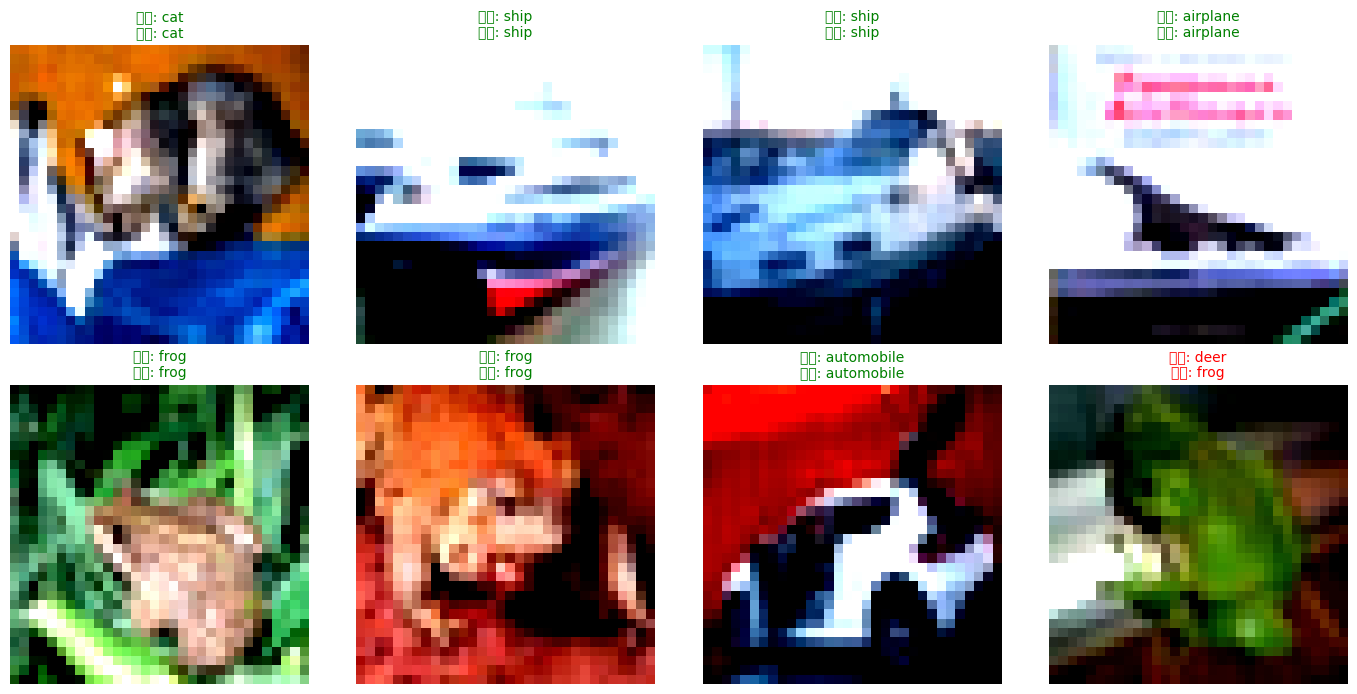


这批样本的准确率: 87.50% (28/32)


In [11]:
# 加载最佳模型
checkpoint = torch.load(str(BEST_CKPT_PATH), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ 加载最佳模型 (Epoch {checkpoint['epoch']}, 准确率: {checkpoint['test_acc']:.2f}%)")

# 获取测试样本
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)

# 预测
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# 可视化预测结果
images_np = images.cpu()
predicted_np = predicted.cpu()
labels_np = labels.cpu()

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for idx, ax in enumerate(axes.flat):
    if idx < 8:
        img = images_np[idx].numpy() / 2 + 0.5
        ax.imshow(np.transpose(img, (1, 2, 0)))
        
        pred_label = classes[predicted_np[idx]]
        true_label = classes[labels_np[idx]]
        color = 'green' if predicted_np[idx] == labels_np[idx] else 'red'
        
        ax.set_title(f'预测: {pred_label}\n真实: {true_label}', color=color, fontsize=10)
        ax.axis('off')
        
plt.tight_layout()
plt.show()

# 计算准确率
correct = (predicted_np == labels_np).sum().item()
print(f"\n这批样本的准确率: {100. * correct / len(labels):.2f}% ({correct}/{len(labels)})")

✅ 加载最佳模型 (Epoch 10, 准确率: 72.85%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

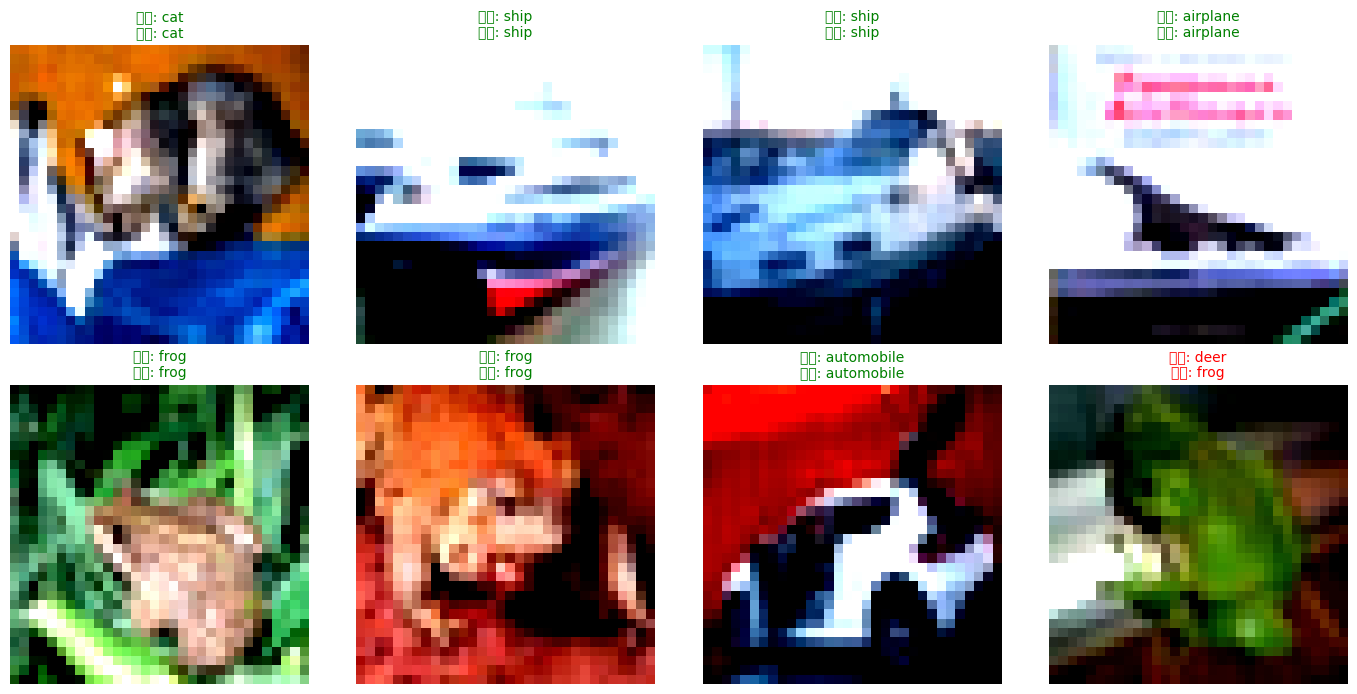


这批样本的准确率: 87.50% (28/32)


In [12]:
# 加载最佳模型
checkpoint = torch.load(str(BEST_CKPT_PATH), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ 加载最佳模型 (Epoch {checkpoint['epoch']}, 准确率: {checkpoint['test_acc']:.2f}%)")

# 获取测试样本
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(DEVICE), labels.to(DEVICE)

# 预测
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.max(1)

# 可视化预测结果
images_np = images.cpu()
predicted_np = predicted.cpu()
labels_np = labels.cpu()

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for idx, ax in enumerate(axes.flat):
    if idx < 8:
        img = images_np[idx].numpy() / 2 + 0.5
        ax.imshow(np.transpose(img, (1, 2, 0)))
        
        pred_label = classes[predicted_np[idx]]
        true_label = classes[labels_np[idx]]
        color = 'green' if predicted_np[idx] == labels_np[idx] else 'red'
        
        ax.set_title(f'预测: {pred_label}\n真实: {true_label}', color=color, fontsize=10)
        ax.axis('off')
        
plt.tight_layout()
plt.show()

# 计算准确率
correct = (predicted_np == labels_np).sum().item()
print(f"\n这批样本的准确率: {100. * correct / len(labels):.2f}% ({correct}/{len(labels)})")

各类别准确率:
----------------------------------------
airplane    :  79.80% (798/1000)
automobile  :  80.40% (804/1000)
bird        :  61.90% (619/1000)
cat         :  47.30% (473/1000)
deer        :  69.20% (692/1000)
dog         :  70.20% (702/1000)
frog        :  84.50% (845/1000)
horse       :  71.20% (712/1000)
ship        :  83.80% (838/1000)
truck       :  80.20% (802/1000)


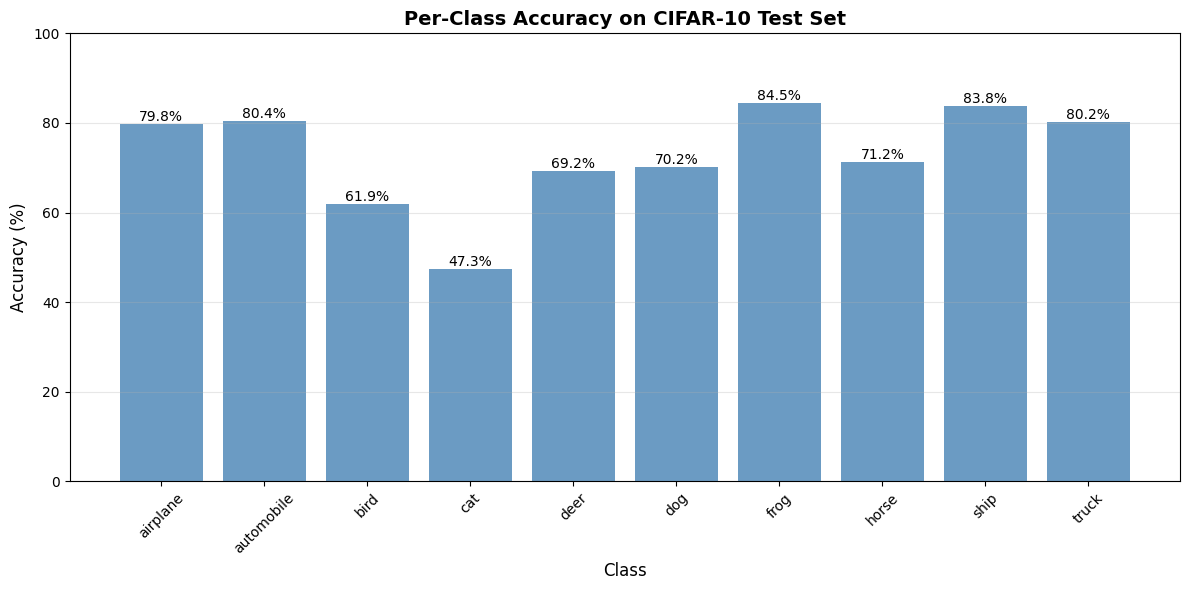

In [13]:
# 在整个测试集上评估
class_correct = [0] * NUM_CLASSES
class_total = [0] * NUM_CLASSES

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        c = (predicted == targets)
        for i in range(len(targets)):
            label = targets[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 打印每个类别的准确率
print("各类别准确率:")
print("-" * 40)
for i in range(NUM_CLASSES):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"{classes[i]:<12}: {acc:>6.2f}% ({class_correct[i]}/{class_total[i]})")

# 绘制柱状图
class_acc = [100 * class_correct[i] / class_total[i] for i in range(NUM_CLASSES)]
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, class_acc, color='steelblue', alpha=0.8)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy on CIFAR-10 Test Set', fontsize=14, fontweight='bold')
plt.ylim([0, 100])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 在柱子上标注数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 12. 保存训练摘要

In [14]:
# 保存训练摘要
import json
from datetime import datetime

summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'embed_dim': EMBED_DIM,
        'depth': DEPTH,
        'num_heads': NUM_HEADS,
    },
    'results': {
        'best_test_acc': best_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_test_acc': history['test_acc'][-1],
    },
    'class_accuracy': {classes[i]: class_acc[i] for i in range(NUM_CLASSES)},
    'history': history
}

with open(LOG_DIR / 'training_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"✅ 训练摘要已保存到 {LOG_DIR / 'training_summary.json'}")
print("\n训练总结:")
print("="*50)
print(f"训练轮数: {EPOCHS}")
print(f"最佳测试准确率: {best_acc:.2f}%")
print(f"最终训练准确率: {history['train_acc'][-1]:.2f}%")
print(f"最终测试准确率: {history['test_acc'][-1]:.2f}%")
print(f"模型参数量: {total_params:,}")
print("="*50)

✅ 训练摘要已保存到 logs/exp_003/training_summary.json

训练总结:
训练轮数: 10
最佳测试准确率: 72.85%
最终训练准确率: 75.19%
最终测试准确率: 72.85%
模型参数量: 4,771,082
